In [1]:
from datetime import datetime, timedelta
import os
import time
import requests
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import doctor
import math
from IPython.display import clear_output
import main
import seaborn as sea
import matplotlib.patches as patches
import matplotlib as mpl
import ryan_tools as rt
import keras as kr
import glob

C:\Users\rfrancis\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Open

In [2]:
def plot_candles(candles, signal, fig, ax):
    def add_rectangle(i, open_, close,low, high, ax, sig):
        x = i - .5
        y = min(open_, close)
        height = abs(open_ - close)
        if sig == 'buy':
            color = 'green'
            hatch = 'x'
        if sig == 'sell':
            color = 'red'
            hatch = ''
            
        if sig == 'wait':
            color = 'orange'
            hatch = ''
        ax.add_patch(patches.Rectangle((x, y), .9, height,
                                       fill = open_ <= close, facecolor = color,
                                       edgecolor = color, hatch = hatch ))
        top = max(open_,close)
        bottom = min(open_,close)

        if low < bottom:
            ax.add_line(mpl.lines.Line2D([i,i], [low, bottom], color = color) )

            
        if high > top:
            ax.add_line(mpl.lines.Line2D([i,i], [high, top], color = color) )

        
    for i, index in enumerate(candles.index):
        sig = signal.loc[index]
        row = candles.loc[index]
        add_rectangle(i, row['open'], row['close'],row['low'], row['high'],  ax, sig)
    ax.set_xlim(0, len(candles))
    ax.set_ylim(candles['close'].min() *.998, candles['close'].max() * 1.002)
    return ax

In [3]:
def chartio(gran = 60, cans = False, count = False):
    if type(cans) == type(False):
        cans = aba.get_candles(granularity= gran)
    if count == False:
        count = len(cans)
    mask = cans['open']< cans['close']
    signal = pd.Series(index = cans.index )
    signal.loc[mask] = 'buy'
    signal.loc[~mask] = 'sell'

    
    
    fig, (ax, sig_ax) = plt.subplots(nrows = 2, sharex= False)
    fig.set_size_inches(7, 9)
    plot_candles(cans[-count:], signal[-count:], fig, ax)
    ax.set_xticklabels(cans.index)
    ax2 = ax.twinx()
    cans.iloc[-count:]['volume'].plot(kind = 'bar', ax = ax2, alpha = 0.3)
    

    rsi = aba.get_rsi(cans['close'])
    macd = aba.get_macd(cans)
    rsi.plot(ax = sig_ax, alpha = 0.1)
    ax4 = sig_ax.twinx()
    macd[['macd', 'macd_signal']].plot(ax = ax4)
    plt.show()
    

In [4]:
aba = main.Abathor('LTC-USD')

In [5]:
def save_observations(observations):
    for i, df in enumerate( observations):
        dire = os.getcwd() + '\\data\\{}.pkl'.format(i)
        df.to_pickle(dire)

In [6]:
def load_observations():
    observations = []
    os.chdir('data')
    for file in glob.glob('*.pkl'):
        observations.append(pd.read_pickle(file))
    os.chdir('..')
    return observations

In [7]:
observations = load_observations()
save_observations(observations)

In [8]:
def get_random_candles(seconds = 60.00):
    days = np.random.randint(1, 500)
    hours = np.random.randint(0, 12)
    minutes = np.random.randint(0,60)
    start = datetime.today() - timedelta(days = days, hours = hours, minutes = minutes )
    end = start + timedelta(seconds = seconds * 200)
    cans =  aba.get_candles(start, end, granularity = seconds)
    observations.append(cans)
    save_observations(observations)
    return cans

In [9]:
#to_download = 100
#bar = rt.progress_bar(to_download)
#for num in range(0, to_download):
#    get_random_candles()
#    bar.progress()

In [154]:

def process_y(y):
    temp = pd.DataFrame(y, columns = ['y'])
    temp.loc[temp['y'] > 0, 'new_y'] = 1
    temp.loc[temp['y'] < 0, 'new_y'] = 2
    temp.loc[temp['y'] == 0, 'new_y'] = 0
    y = temp['new_y'].values
    return kr.utils.to_categorical(y)
    
    

In [155]:
def make_changes(candles):
    changes = candles.copy()
    candles['minutes'] = (candles.index - candles.index.min()).seconds / 60
    changes[['low', 'high', 'open', 'close', 'volume']] =  changes[['low', 'high', 'open', 'close', 'volume']].pct_change()
    changes['minutes'] = candles['minutes']
    
    del changes['timestamp']
    changes = changes.dropna()
    return changes

def create_data(candle_list, candles_before = 10):
    X = []
    y = []
    ar = np.array
    bar = rt.progress_bar(len(candle_list))
    for candles in candle_list:
        bar.progress()
        changes = make_changes(candles)

        for index in changes.index:
            change_percent = changes.loc[index, 'close']
            all_before = changes.loc[:index]
            amount = len(all_before)
            if amount > candles_before + 2:
                Xi = all_before.iloc[amount - (candles_before+ 2):amount-2]
                Xi = ar(Xi[['low', 'high', 'open', 'close', 'volume', 'minutes']].values)
                X.append(Xi)
                y.append(change_percent)
    X, y =  ar(X), ar(y)
    y = process_y(y)
    return X, y
    

In [156]:
def make_samples_even(X,y, target_ratio = .8 ):
    X = list(X)
    y = list(y)
    
    def get_ratio(y):
        total = len(y)
        wins = np.sum(y)
        losses = total - wins
        return wins/losses
    
    def add_another(X, y, windexes):
        to_add = np.random.choice(windexes)
        X.append(X[to_add])
        y.append(y[to_add])
    ratio = get_ratio(y)
    
    while ratio < target_ratio:
        windexes = [i for i,val in enumerate(y) if val==1]
        for num in range(0, 500):
            add_another(X, y, windexes)

        ratio = get_ratio(y)
        print(ratio)
        clear_output(True)
        
         
    return np.array(X), np.array(y)


In [139]:
observations = load_observations()

In [157]:
candles_before = 25
X, y = create_data(observations, candles_before)


0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o> | 100.00 % 
Done: 889 Remaining: 1, Remaining Time: 0s


In [159]:
def generate_model(X, y):
    model = kr.models.Sequential()
    model.add(kr.layers.LSTM(2**7, input_shape=X.shape[1:],return_sequences=False))
    #model.add(kr.layers.Dropout(0.05))
    model.add(kr.layers.Dense(32))
    model.add(kr.layers.Dense(y.shape[1]))
    model.add(kr.layers.Activation('softmax'))
    #optimizer = kr.optimizers.RMSprop(lr=0.001)
    optimizer = kr.optimizers.Adam(0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return model

model = generate_model(X, y)

In [143]:
def download_hidden_list(samples = 10):
    hidden_list = []
    bar = rt.progress_bar(samples)
    for num in range(0, samples):
        bar.progress()
        hidden_list.append(get_random_candles(60))
        
    X, y = create_data(hidden_list, candles_before)

    return X, y

In [161]:
hidden_x, hidden_y = download_hidden_list(30)

0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0o0>    | 100.00 % 
Done: 29 Remaining: 1, Remaining Time: 0s


In [145]:
def fit(X, y, epochs = 1, hidden_x = False, hidden_y = False):
    if type(hidden_x) == type(False):
        hidden_x, hidden_y = download_hidden_list(10)
    cbacks = [kr.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')]
    model.fit(X, y, validation_data= (hidden_x, hidden_y), batch_size=1000,  epochs=epochs, verbose = 1, callbacks=cbacks)

In [228]:
fit( X, y, 10, hidden_x,hidden_y )

Train on 126662 samples, validate on 2675 samples
Epoch 1/10
126662/126662 [==============================] - 27s 214us/step - loss: 1.0629 - val_loss: 1.0666
Epoch 2/10
126662/126662 [==============================] - 27s 214us/step - loss: 1.0621 - val_loss: 1.0696
Epoch 3/10
126662/126662 [==============================] - 28s 218us/step - loss: 1.0627 - val_loss: 1.0665
Epoch 4/10
126662/126662 [==============================] - 27s 213us/step - loss: 1.0620 - val_loss: 1.0658
Epoch 5/10
126662/126662 [==============================] - 27s 213us/step - loss: 1.0615 - val_loss: 1.0675
Epoch 6/10
126662/126662 [==============================] - 27s 213us/step - loss: 1.0621 - val_loss: 1.0647
Epoch 7/10
126662/126662 [==============================] - 27s 213us/step - loss: 1.0620 - val_loss: 1.0653
Epoch 8/10
126662/126662 [==============================] - 27s 214us/step - loss: 1.0617 - val_loss: 1.0647
Epoch 9/10
126662/126662 [==============================] - 27s 213us/step - l

In [147]:
def evaluate( X = False, y = False):
    if type(X) == type(False):
        X, y = download_hidden_list(10)
    preds = model.predict(X)    
    comparison = pd.DataFrame()
    comparison['preds'] = preds.reshape(len(preds))
    comparison['preds'] = comparison['preds'].apply(lambda x: round(x, 4))
    comparison['y'] = y
    return preds, comparison

preds, comparison = evaluate(hidden_x, hidden_y)

ValueError: cannot reshape array of size 13120 into shape (3280,)

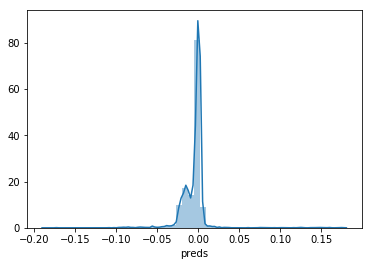

In [59]:
sea.distplot(comparison['preds'])
plt.show()

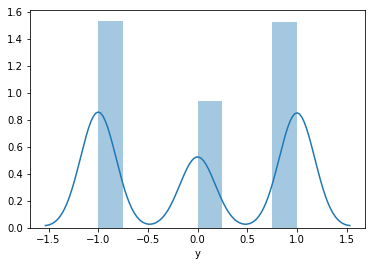

In [60]:
sea.distplot(comparison['y'])
plt.show()

In [61]:
comparison['status'] = 'None'
mask = (comparison['preds'] == 0) & (comparison['y'] == 0)
comparison.loc[mask, 'status'] = '0'

mask = (comparison['preds'] > 0) & (comparison['y'] > 0)
comparison.loc[mask, 'status'] = '-'

mask = (comparison['preds'] < 0) & (comparison['y'] < 0)
comparison.loc[mask, 'status'] = '+'

In [62]:
comparison['wrong'] = comparison['y'] - comparison['preds']

In [63]:
comparison['wrong'].median()

0.0012

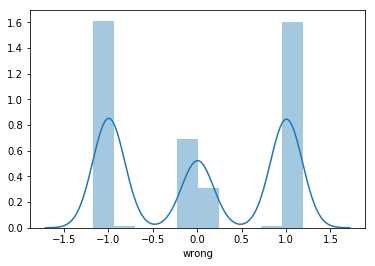

In [64]:
sea.distplot(comparison['wrong'])
plt.show()

In [165]:
def predict_next_move( seconds = 60.00):
    end = datetime.today()
    start = end - timedelta(seconds = seconds * 200)
    cans =  aba.get_candles(start, end, granularity = seconds)
    return cans


In [172]:
preds = model.predict(hidden_x)

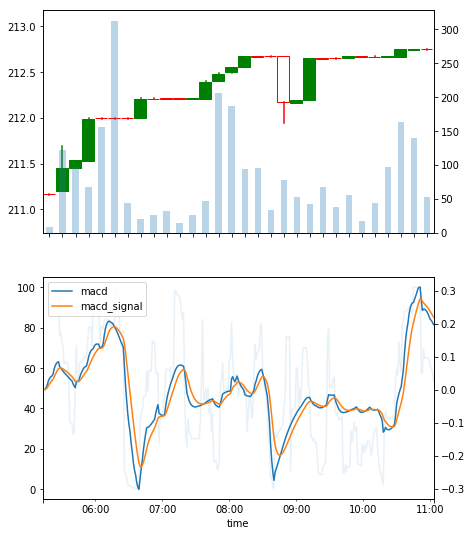

[[0.1602652  0.44711986 0.392615  ]]


low                 212.74
high                212.75
open                212.75
close               212.75
volume               52.76
timestamp    1520276580.00
minutes             350.00
Name: 2018-03-05 11:03:00, dtype: object

In [296]:
cans = predict_next_move(60)
chartio(cans = cans, count = 30)
changes = make_changes(cans)
changes = changes.iloc[-candles_before:][['low', 'high', 'open', 'close', 'volume', 'minutes']]
changes = changes.values.reshape((1, changes.shape[0], changes.shape[1]))
#print('Prediction:',model.predict(changes)[0][0] * cans.loc[cans.index.min(), 'open'])
print(model.predict(changes))
cans.loc[cans.index.max()].apply(lambda x: '{:.2f}'.format(x))

In [283]:
avgs = pd.DataFrame(model.predict(X))

In [297]:
def convert_prediction(preds):
    data = pd.DataFrame(preds)
    for t in data.columns:
#        data[t] = data[t]/avgs[t].std()
        data[t] = data[t] - avgs[t].mean()

    data['prediction'] = data[[0,1,2]].apply(lambda x: np.argmax(x), axis = 1)
    data['prediction'] = data['prediction'].replace(1, 'up').replace(0, 'same').replace(2, 'down')
    return data

In [299]:
x = convert_prediction(model.predict(changes))
x


,0,1,2,prediction
0,-0.068173,0.04036,0.027764,up


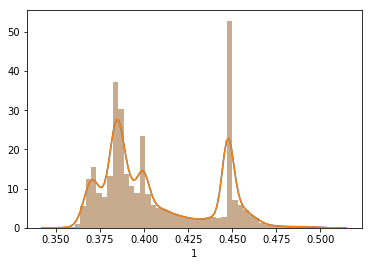

In [302]:
sea.distplot(avgs[1])
plt.show()

In [305]:
test = avgs.copy()

In [306]:
test['up'] = avgs[1] > .425

In [308]:
test['resup'] = pd.DataFrame(y)[1] > 0

In [312]:
test['up'].value_counts()

False    88267
True     38395
Name: up, dtype: int64

In [313]:
test['resup'].value_counts()

False    75539
True     51123
Name: resup, dtype: int64

In [318]:
test[test['up']]['resup'].value_counts()

False    21412
True     16983
Name: resup, dtype: int64

In [320]:
test[~test['up']]['resup'].value_counts()

False    54127
True     34140
Name: resup, dtype: int64

In [304]:
pd.DataFrame(y)

,0,1,2
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,1.0,0.0,0.0
8,0.0,1.0,0.0
9,0.0,0.0,1.0
